# Scrape and analyzing kost-kostan in South Jakarta

## Scraping the data from sewakost website

In [2]:
import requests
import pandas as pd
from tqdm import tqdm

In [ ]:
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")

In [21]:
url_query = "https://www.sewakost.com/jakarta/selatan/"
req = requests.get(url_query, verify=False)
soup = BeautifulSoup(req.content, "html.parser")
str(soup)[:100]

'<!DOCTYPE html>\n\n<html lang="id" xmlns="http://www.w3.org/1999/xhtml">\n<head>\n<title>Kost Jakarta Se'

In [3]:
try:
    find_pagination = soup.find("ul", attrs = {"class": "pagination"})
    find_span = find_pagination.findAll("span")
    total_page = int(find_span[1].text[-2:])
    print("Total Page: {}".format(total_page))
except:
    print("Article Not Found")

Total Page: 89


In [11]:
sewakost = []

for page_num in tqdm(range(1, total_page+1)[:40]):
    url_sewakost = "https://www.sewakost.com/jakarta/selatan/index%s.html" % page_num
    # print(url_sewakost)
    r = requests.get(url_sewakost, verify=False)
    s = BeautifulSoup(r.content, "html.parser")
    
    find_kos = s.findAll("div", attrs = {"class": "main-column clearfix"})
    for row in find_kos:
        try:
          kos = {}
          kos['url'] = row.ul.li.a['href']
          kos['nama'] = row.ul.li.a['title']
          harga = row.find("span", attrs = {"class": "price-tag"})
          kos['harga'] = harga.span.text
          sewakost.append(kos)
        except:
          continue
        

100%|██████████| 40/40 [00:58<00:00,  1.46s/it]


In [12]:
pd.DataFrame(sewakost)

,url,nama,harga
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,Rp 1.000.000
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,Rp 2.200.000
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,Rp 850.000
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,Rp 2.700.000
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,Rp 2.500.000
...,...,...,...
953,https://www.sewakost.com/jakarta/selatan/kost-...,Kost lokasi Strategis dan Aman,Rp 2.200.000
954,https://www.sewakost.com/jakarta/selatan/kosan...,Kosan 28 Duren Tiga (Bangunan Baru!!),Rp 1.100.000
955,https://www.sewakost.com/jakarta/selatan/kost-...,"Kost Khusus Putra di Tebet Timur Dalam 7G, Jak...",Rp 1.900.000
956,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Putri Qtha,Rp 1.400.000


In [24]:
for kos in tqdm(sewakost):
  try:
    req_kos = requests.get(kos['url'], verify = False)
    soup_kos = BeautifulSoup(req_kos.content, "html.parser")

    informasi = ['jenis', 'address', 'aircon', 'free_wifi', 'kamar_mandi_dalam']

    for info in informasi:
      value = soup_kos.find("div", attrs={"id": "df_field_%s" % info}).find("div", attrs={"class":"value"})
      kos[info] = value.text.strip()

    kos['fasilitas_kamar'], kos['fasilitas_kost'] = [], []
    fasilitas = ['fasilitas_kamar', 'fasilitas_kost']

    for f in fasilitas:
      list_f = soup_kos.find("div", attrs={"id": "df_field_%s" % f}).find("div", attrs={"class":"value"})
      for each_f in list_f.findAll("li"):
        kos[f].append(each_f['title'])

  except:
    pass

100%|██████████| 958/958 [23:26<00:00,  1.47s/it]


In [ ]:
pd.DataFrame(sewakost).to_csv('sewakost_40pages.tsv', sep="\t", index=False)

## Data Preparation

In [3]:
df = pd.read_csv('sewakost_40pages.tsv', sep="\t")

df.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,Rp 1.000.000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,['Kamar Mandi Dalam'],"['Keamanan', 'Parkir Motor']"
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,Rp 2.200.000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,Rp 850.000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,[],[]
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,Rp 2.700.000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,Rp 2.500.000,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,"['AC', 'Kamar Mandi Dalam']","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."


In [4]:
df.isnull().sum()

url                   0
nama                  0
harga                 0
jenis                14
address              14
aircon               14
free_wifi            14
kamar_mandi_dalam    14
fasilitas_kamar      14
fasilitas_kost       14
dtype: int64

In [5]:
df[df.isnull().any(axis=1)]

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
483,https://www.sewakost.com/jakarta/selatan/indek...,INDEKOS ELITE DALAM CLUSTER FULL FURNISH,3.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
739,https://www.sewakost.com/jakarta/selatan/tebet...,TEBET EXECUTIVE RESIDENCE 141,3.550.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
740,https://www.sewakost.com/jakarta/selatan/sewa-...,"Sewa Kost, Cilandak Barat, Jakarta Selatan",2.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,https://www.sewakost.com/jakarta/selatan/kos-d...,Kos di Lt.Agung dkt KRL Lt.Agung & Tj.Brt,700.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Wanita Tebet Dekat Pasar Tebet Barat dan ...,1.600.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
743,https://www.sewakost.com/jakarta/selatan/kos-p...,Kos Putri Strategis,700.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
744,https://www.sewakost.com/jakarta/selatan/kos-k...,Kos khusus wanita,1.500.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745,https://www.sewakost.com/jakarta/selatan/koen-...,Koen View Residence Radio Dalam,6.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
746,https://www.sewakost.com/jakarta/selatan/kos-d...,Kos di Lt.Agung dkt kampus dan KRL,700.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
747,https://www.sewakost.com/jakarta/selatan/kost-...,KOST ELITE CAMPUR FULL FURNISH JAKARTA SELATAN...,3.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.dropna(inplace=True)

df.isnull().sum()

url                  0
nama                 0
harga                0
jenis                0
address              0
aircon               0
free_wifi            0
kamar_mandi_dalam    0
fasilitas_kamar      0
fasilitas_kost       0
dtype: int64

In [7]:
import re as re

def find_number(text):
    try:
        num = "".join(re.findall(r'[\d]+',text))
        return int(num)
    except:
        return 0

df['harga'] = df['harga'].apply(lambda x: find_number(x))

df.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,1000000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,['Kamar Mandi Dalam'],"['Keamanan', 'Parkir Motor']"
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,2200000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,850000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,[],[]
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,2700000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,2500000,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,"['AC', 'Kamar Mandi Dalam']","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."


In [8]:
df.dtypes

url                  object
nama                 object
harga                 int64
jenis                object
address              object
aircon               object
free_wifi            object
kamar_mandi_dalam    object
fasilitas_kamar      object
fasilitas_kost       object
dtype: object

In [9]:
df.describe()

,harga
count,9.440000e+02
mean,3.816841e+09
std,8.280764e+10
min,0.000000e+00
25%,1.000000e+06
50%,1.650000e+06
75%,2.350000e+06
max,1.800000e+12


In [10]:
df.shape

(944, 10)

In [11]:
# Cek harga kos di bawah 10.000
df[(df['harga']<10000) | (df['harga']>5000000)].shape

(71, 10)

In [12]:
df = df[(df['harga']>10000) & (df['harga']<5000000)]

df.shape

(865, 10)

In [13]:
df.describe()

,harga
count,8.650000e+02
mean,1.794082e+06
std,9.085083e+05
min,1.800000e+05
25%,1.000000e+06
50%,1.650000e+06
75%,2.300000e+06
max,4.900000e+06


In [14]:
df['jenis'].unique()

array(['Kost Campur', 'Kost Putra', 'Kost Putri', 'Kost Pasutri',
       'Kost Keluarga'], dtype=object)

In [15]:
df.dtypes

url                  object
nama                 object
harga                 int64
jenis                object
address              object
aircon               object
free_wifi            object
kamar_mandi_dalam    object
fasilitas_kamar      object
fasilitas_kost       object
dtype: object

In [16]:
df['jenis'] = df['jenis'].replace('Kost Pasutri', 'Kost Keluarga')

categorical = ['jenis', 'aircon', 'free_wifi', 'kamar_mandi_dalam']
df[categorical] = df[categorical].astype('category')

df.dtypes

url                    object
nama                   object
harga                   int64
jenis                category
address                object
aircon               category
free_wifi            category
kamar_mandi_dalam    category
fasilitas_kamar        object
fasilitas_kost         object
dtype: object

In [17]:
df.groupby('jenis').count()

,url,nama,harga,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
jenis,,,,,,,,,
Kost Campur,477,477,477,477,477,477,477,477,477
Kost Keluarga,22,22,22,22,22,22,22,22,22
Kost Putra,109,109,109,109,109,109,109,109,109
Kost Putri,257,257,257,257,257,257,257,257,257


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

## Visualization

### Tipe Kos

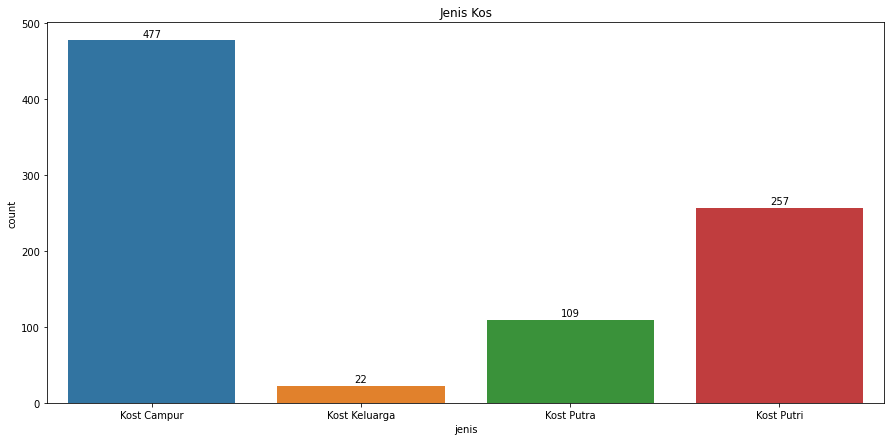

In [19]:
plt.figure(figsize=(15,7))
g = sns.countplot(x=df['jenis'])
plt.title('Jenis Kos')
for p in g.patches:
  g.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+5), ha='center', color='black', size=10)

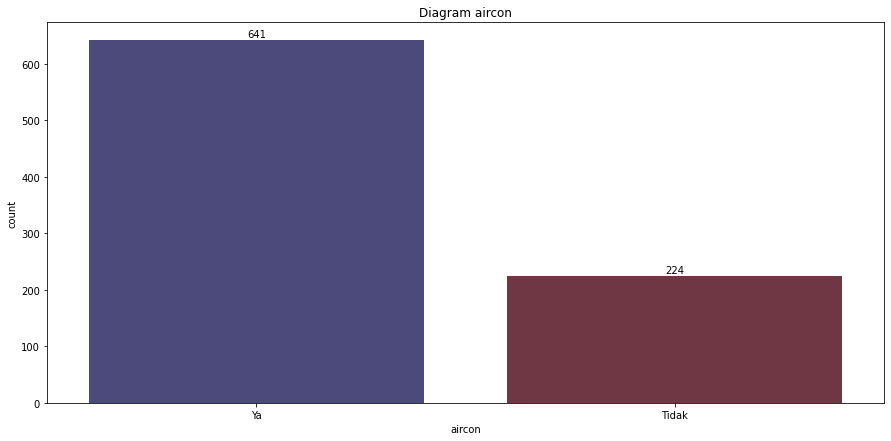

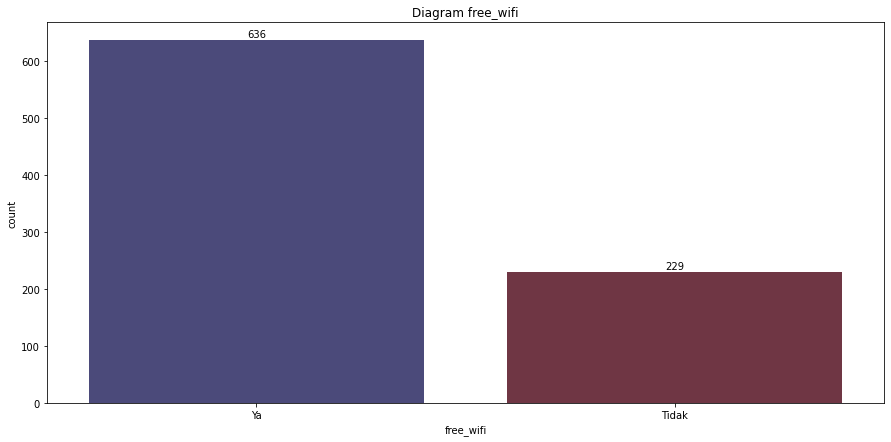

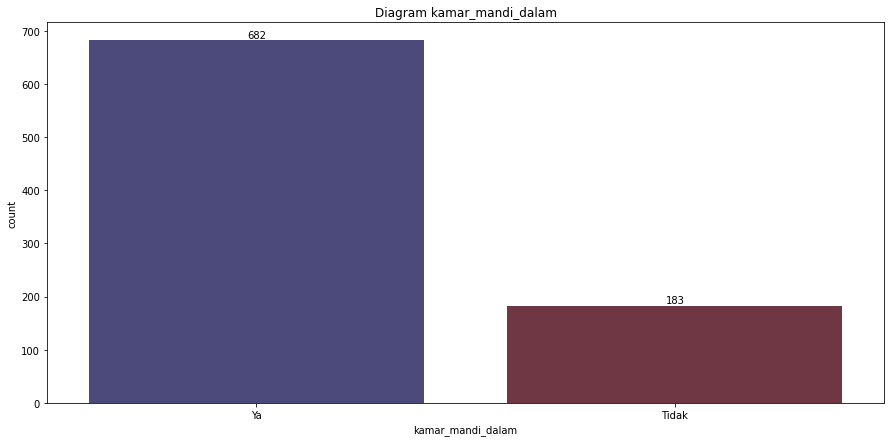

In [20]:
fas = ['aircon', 'free_wifi', 'kamar_mandi_dalam']
for i in fas:
    plt.figure(figsize=(15,7))
    g = sns.countplot(x = df[i], palette = 'icefire', order=['Ya', 'Tidak'])
    plt.title('Diagram {}'.format(i))
    for p in g.patches:
        g.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+5), ha='center', color='black', size=10)

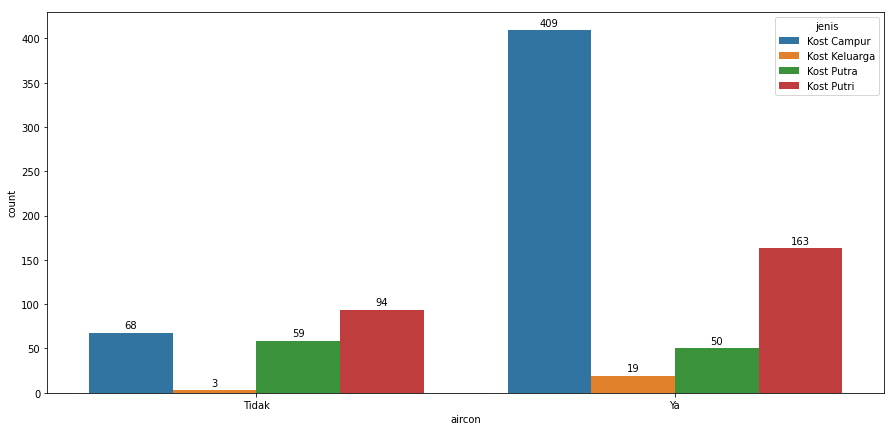

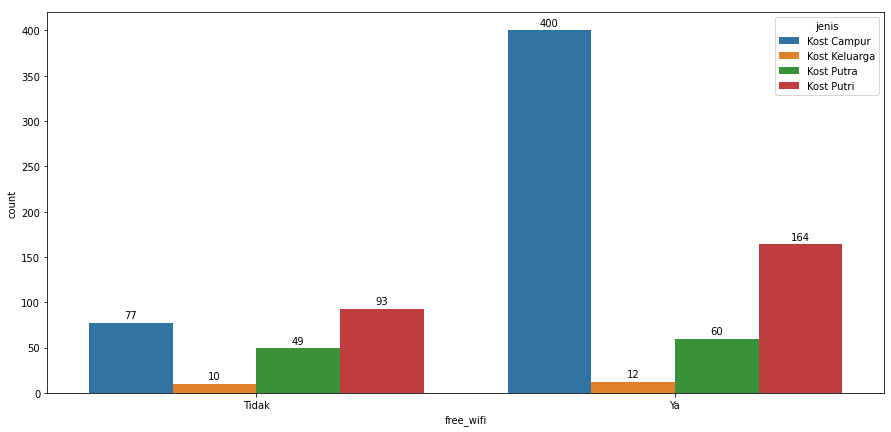

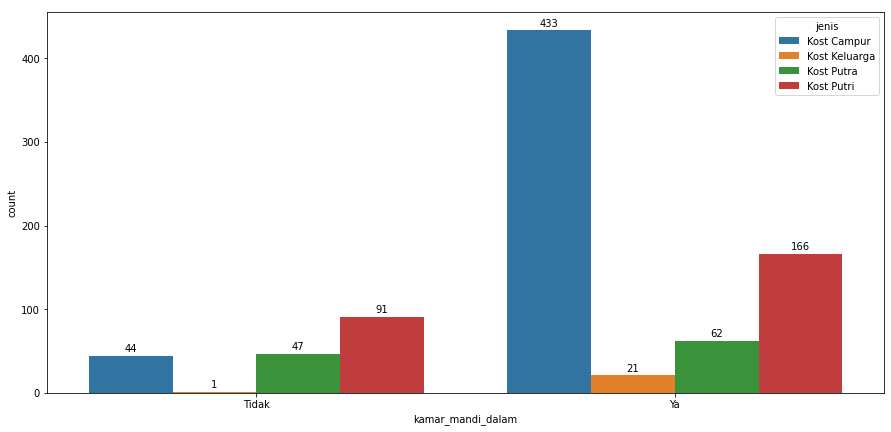

In [21]:
for i in fas:
    plt.figure(figsize=(15,7))
    g = sns.countplot(data=df, x=i, hue="jenis")
    for p in g.patches:
        g.annotate(f'\n{p.get_height()}', (p.get_x()+0.1, p.get_height()+5), ha='center', color='black', size=10)

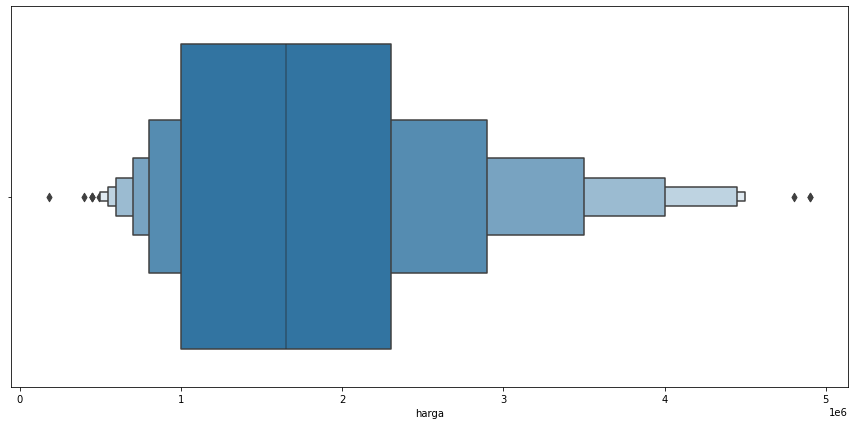

In [22]:
plt.figure(figsize=(15,7))
sns.boxenplot(x=df['harga']);

In [95]:
wifi = df['free_wifi'] == 'Ya'
ac = df['aircon'] == 'Ya'
no_ac = df['aircon'] == 'Tidak'
kamar_mandi = df['kamar_mandi_dalam'] == 'Ya'
no_kamar_mandi = df['kamar_mandi_dalam'] == 'Tidak'

lengkap = df[ac & wifi & kamar_mandi]
wifi_kamar_mandi = df[wifi & kamar_mandi & no_ac]
wifi_ac = df[ac & wifi & no_kamar_mandi]
# # Alternatif menggunakan .loc
# kost_lengkap = df.loc[(df[['aircon', 'free_wifi','kamar_mandi_dalam']]=='Ya').all(axis=1)]

lengkap.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,2200000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,2700000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
8,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EKSLUSIF DI JAKARTA SELATAN,850000,Kost Campur,JL. Kapten tendean no.2A (dekat kampus interst...,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Mesin Cuci (Cuci Sendiri)', 'Parkir..."
11,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Premium Termurah Daerah Mampang Jakarta S...,1650000,Kost Campur,"Jalan Bank III No 1 Kelurahan Pela Mampang, Ma...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Dapur', 'Air Minum', 'Pembantu..."
13,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Rumah Kita 1A,1800000,Kost Campur,"Pondok Jaya 3 No 1A, Pela Mampang, Mampang Pra...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...",['Parkir Motor']


In [96]:
lengkap.describe()

,harga
count,5.050000e+02
mean,2.222331e+06
std,8.361045e+05
min,1.800000e+05
25%,1.600000e+06
50%,2.000000e+06
75%,2.500000e+06
max,4.900000e+06


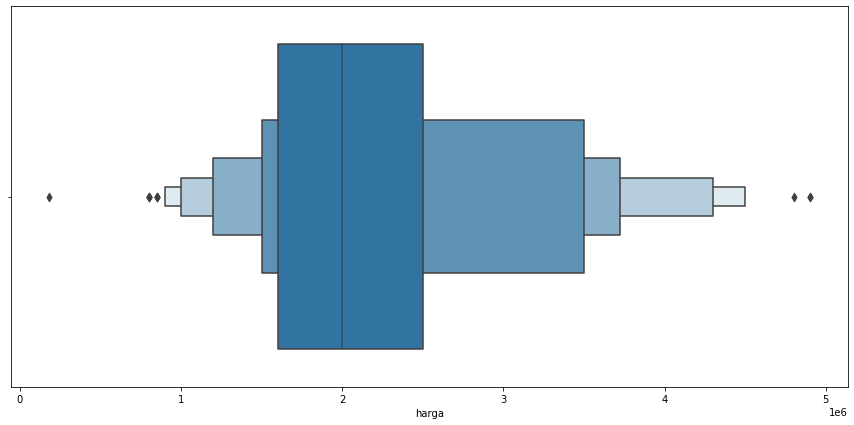

In [97]:
plt.figure(figsize=(15,7))
sns.boxenplot(x=lengkap['harga']);

In [98]:
wifi_kamar_mandi.describe()

,harga
count,3.500000e+01
mean,1.054286e+06
std,2.682655e+05
min,5.000000e+05
25%,9.000000e+05
50%,1.000000e+06
75%,1.200000e+06
max,1.700000e+06


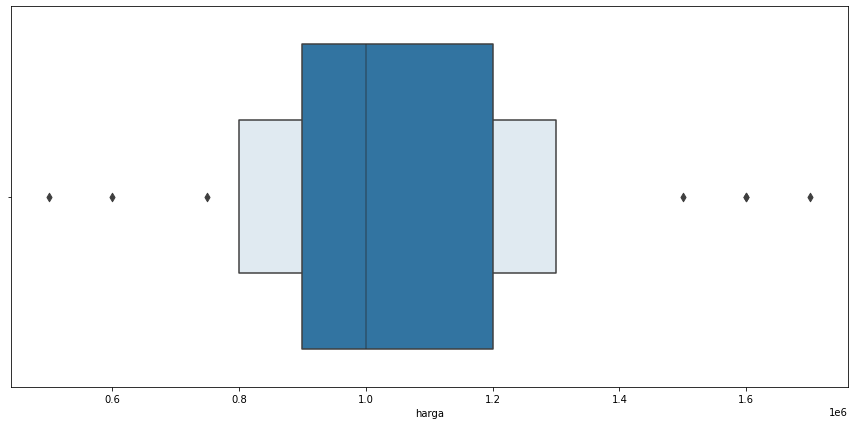

In [99]:
plt.figure(figsize=(15,7))
sns.boxenplot(x=wifi_kamar_mandi['harga']);

In [100]:
wifi_ac.describe()

,harga
count,4.600000e+01
mean,1.509783e+06
std,4.728894e+05
min,6.000000e+05
25%,1.200000e+06
50%,1.500000e+06
75%,1.800000e+06
max,3.000000e+06


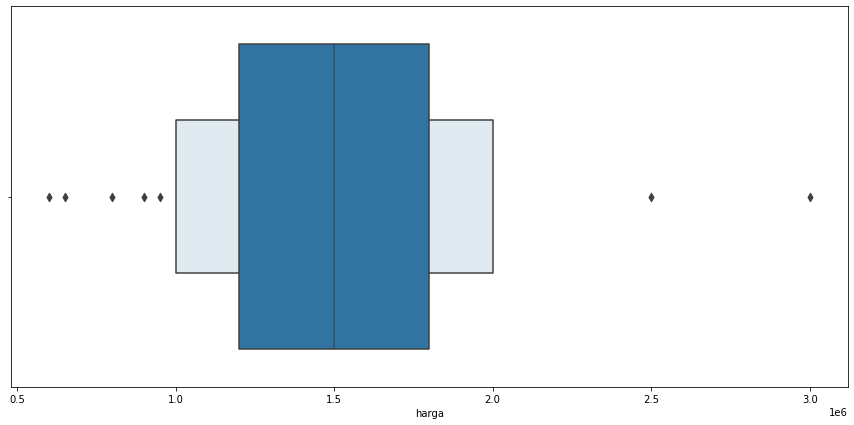

In [101]:
plt.figure(figsize=(15,7))
sns.boxenplot(x=wifi_ac['harga']);

## Analisis Lanjutan Kost Lengkap

In [78]:
under_Q1 = lengkap['harga'] < lengkap.harga.quantile(0.25)
extreme_underprice = lengkap['harga'] < 1000000

lengkap[under_Q1]

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
2,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EKSLUSIF DI JAKARTA SELATAN,850000,Kost Campur,JL. Kapten tendean no.2A (dekat kampus interst...,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Mesin Cuci (Cuci Sendiri)', 'Parkir..."
9,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Puspita 19,1500000,Kost Putri,"Taman Shangrila Unit I, Jl. Shangrila III/105,...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Dapur', 'Air Minum', 'Cuci Set..."
13,https://www.sewakost.com/jakarta/selatan/kost-...,"KOST LENTENG AGUNG ""Khusus Wanita""",800000,Kost Putri,"Jl.Guru No.21 Rt.006/ 002, Lenteng Agung Jakar...",Ya,Ya,Ya,"['Spring Bed', 'Free WiFi', 'AC', 'Kamar Mandi...","['Ruang Makan', 'Dapur', 'Keamanan', 'Parkir M..."
18,https://www.sewakost.com/jakarta/selatan/kost-...,kost murah di cengkareng,1500000,Kost Putra,jakarta,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Televisi', 'Ruang Makan', 'Dap..."
20,https://www.sewakost.com/jakarta/selatan/kost-...,"Kost Menteng Dalam, Tebet , Sudah Termasuk Lis...",1550000,Kost Campur,"Menteng Dalam, Tebet",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Air Minum', 'Keamanan', 'Parkir Mot..."
...,...,...,...,...,...,...,...,...,...,...
482,https://www.sewakost.com/jakarta/selatan/sewa-...,Sewa Kost Strategis di Tebet,1500000,Kost Campur,Tebet Barat,Ya,Ya,Ya,[],[]
484,https://www.sewakost.com/jakarta/selatan/kosko...,Koskosan baru wanita,1500000,Kost Putri,Br,Ya,Ya,Ya,[],[]
485,https://www.sewakost.com/jakarta/selatan/kost-...,Kost A9 Fasilitas lengkap Jakarta selatan,1500000,Kost Campur,Jalan kostrad raya no.A9 rt.8/rw.8 (komplek pu...,Ya,Ya,Ya,[],[]
487,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah KOST Kebayoran Baru Blok A dekat stasiun...,1000000,Kost Campur,Kebayoran Baru Blok A JL Ketimun 5 no 6,Ya,Ya,Ya,[],[]


In [79]:
lengkap[extreme_underprice]

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
2,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EKSLUSIF DI JAKARTA SELATAN,850000,Kost Campur,JL. Kapten tendean no.2A (dekat kampus interst...,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Mesin Cuci (Cuci Sendiri)', 'Parkir..."
13,https://www.sewakost.com/jakarta/selatan/kost-...,"KOST LENTENG AGUNG ""Khusus Wanita""",800000,Kost Putri,"Jl.Guru No.21 Rt.006/ 002, Lenteng Agung Jakar...",Ya,Ya,Ya,"['Spring Bed', 'Free WiFi', 'AC', 'Kamar Mandi...","['Ruang Makan', 'Dapur', 'Keamanan', 'Parkir M..."
28,https://www.sewakost.com/jakarta/selatan/sewa-...,Sewa Penginapan didaerah Blok-M,180000,Kost Campur,"Jl.Iskandarsyah I no 26, Melawai, Jakarta Keba...",Ya,Ya,Ya,"['Spring Bed', 'Free WiFi', 'AC', 'TV', 'Kamar...",[]
30,https://www.sewakost.com/jakarta/selatan/terim...,Terima Kost di Lokasi strategis,900000,Kost Campur,"Jl Rambutan, Kel Manggarai Selatan, belakang M...",Ya,Ya,Ya,"['AC', 'Kamar Mandi Dalam']","['Dapur', 'Parkir Motor']"
74,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Griya Baiti Jannati,900000,Kost Campur,Jl. Kalibata Utara V Rt. 008 Rw. 02 No. 16,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."
79,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EKSKLUSIF DI JAKARTA SELATAN,800000,Kost Campur,"Jl. Kapten Tendean no.2A Pela Mampang, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Free WiFi', 'AC', 'TV', 'Kulka...","['Dapur', 'Mesin Cuci (Cuci Sendiri)', 'Parkir..."
100,https://www.sewakost.com/jakarta/selatan/kost-...,Kost jaksel ac dan non ac free listrik air par...,900000,Kost Keluarga,Jagakarsa ciganjur,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Televisi', 'Dapur', 'Mesin Cuc..."
133,https://www.sewakost.com/jakarta/selatan/kost-...,KOST PUTRI,850000,Kost Putri,"Jl. Kebagusan 1 Gang Asem No 111, RT/RW 07/07",Ya,Ya,Ya,"['Perabot', 'Free WiFi', 'AC', 'Kamar Mandi Da...",['Parkir Motor']
249,https://www.sewakost.com/jakarta/selatan/kost-...,KOST GRIYA BAITI JANNATI,900000,Kost Campur,JL. KALIBATA UTARA V RT.008/02 NO. 16 PANCORAN...,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'Kamar ...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."
251,https://www.sewakost.com/jakarta/selatan/d-quo...,"d""orange@jurangmangu",800000,Kost Campur,"jl.Kalimongso RT02/RW01,jurangmangu tangsel",Ya,Ya,Ya,"['AC', 'TV', 'Kamar Mandi Dalam']",['Parkir Motor']
